# Deep Learning

Mahyar jahaninasab




---



---



The transformer is a deep learning model that has become very popular in recent years for various natural language processing (NLP) tasks such as machine translation, text classification, and text generation.

The transformer was introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017 [[link](https://arxiv.org/abs/1706.03762)], and it is based on a novel architecture that replaces traditional recurrent neural networks (RNNs) with self-attention mechanisms. This allows the transformer to process entire sequences of input tokens in parallel, rather than sequentially, making it faster and more efficient than RNN-based models.

In this notebook, we will focus on the structure of the transformer and its different layers. We will start with an overview of the transformer architecture, including the input and output embeddings, the positional encodings, the self-attention layers, and the feedforward layers. We will then dive deeper into each of these layers and explain how they work.

By the end of this notebook, you should have a good understanding of the transformer model and its different layers, as well as how to implement it in PyTorch. This knowledge will be useful for various NLP tasks, and will help you build more advanced deep learning models in the future.

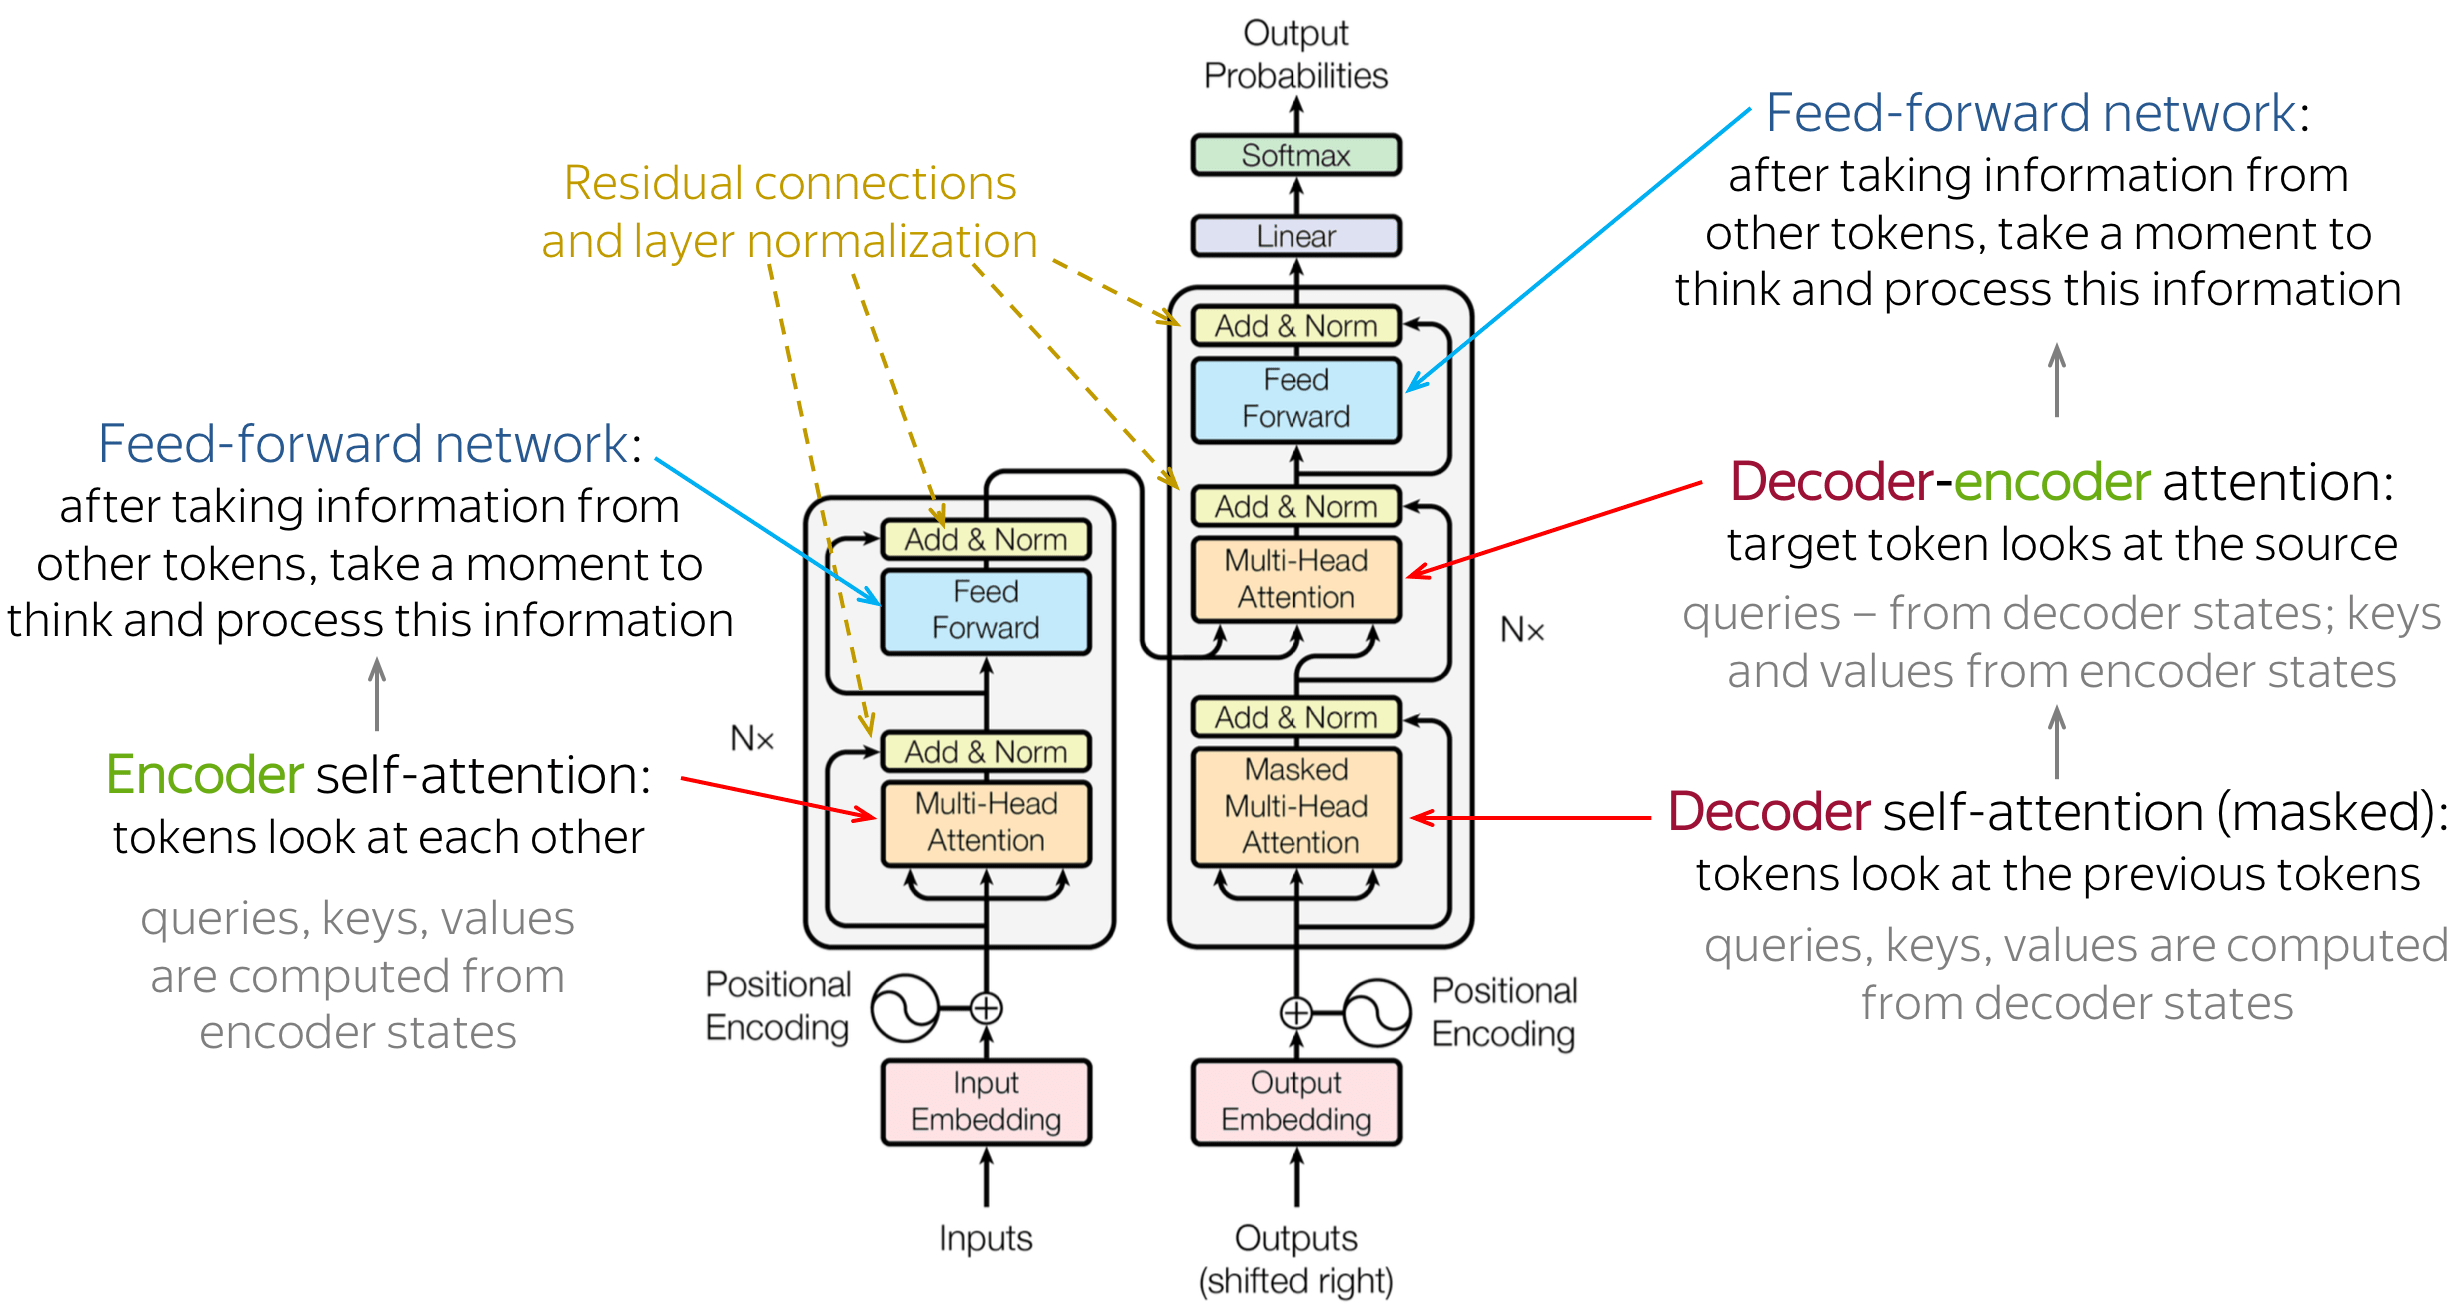



---



---





---



---



# Prelims

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy

# Model Architecture

Our goal in the `EncoderDecoder` class is to build a transformer architecture from scratch.

We'll accomplish this by implementing the code for five key components: the encoder, decoder, source embedding module (`src_embed`), target embedding module (`tgt_embed`), and generator.

In the subsequent sections, we'll provide a step-by-step guide for implementing the code for each of these components. By the end of the notebook, you should have a working implementation of the Encoder-Decoder model that can be trained and evaluated on sequence-to-sequence tasks.

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator


    # ==================================== Complete the Code (Begin) ====================================

    def forward(self, src, tgt, src_mask, tgt_mask): 

        memory = self.encode(src, src_mask) 
        output = self.decode(memory, src_mask, tgt, tgt_mask)
        output_probs = self.generator(output)

        return output_probs  

    def encode(self, src, src_mask): 
        src_embed = self.src_embed(src) 
        memory = self.encoder(src_embed,src_mask) 
        return memory  

    def decode(self, memory, src_mask, tgt, tgt_mask): 
        tgt_embed = self.tgt_embed(tgt) 
        output = self.decoder(tgt_embed,memory,src_mask,tgt_mask) 
        return output
    # ===================================== Complete the Code (End) ====================================


The `Generator` class is responsible for generating the output sequence from the decoder.

It takes in the output of the decoder, which is a sequence of hidden states, and applies a linear transformation followed by a softmax activation to produce a sequence of probability distributions over the output vocabulary.

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    # ==================================== Complete the Code (Begin) ====================================


    def forward(self, x): 
        x = self.proj(x) 
        x = F.softmax(x,dim=-1) 
        return x  

    # ===================================== Complete the Code (End) =====================================

## Encoder and Decoder Stacks

### Encoder

The `Encoder` consists of a stack of identical layers, each of which applies a set of operations to the input sequence to produce a new sequence of hidden states. 

We will implement the structure of each layer in the `Encoder` module using the `EncoderLayer` class, which we will define later.

In [4]:
class Encoder(nn.Module):
    "Core encoder is a stack of N identical layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
        self.norm = LayerNorm(layer.size)

    # ==================================== Complete the Code (Begin) ====================================

    def forward(self, x, mask): 
        for layer in self.layers: 
            x = layer(x, mask) # apply each layer to the input 
        x = self.norm(x) # normalize the output 
        return x  

    # ==================================== Complete the Code (End) ======================================

The `LayerNorm` module is a layer normalization module that is used in the transformer model to normalize the inputs to each layer. The `LayerNorm` module is applied to the output of each layer before it is passed on to the next layer in the stack.

$$ LayerNorm(x)= \gamma.\frac{(x−\mu)}{\sigma+\epsilon} + \beta  $$

where $\mu$ and $\sigma$ are the mean and standard deviation of $x$ along the last dimension, $\epsilon$ is a small value added for numerical stability, and $\gamma$ and $\beta$ are learned scaling and shifting parameters, respectively.

In [5]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    # ==================================== Complete the Code (Begin) ====================================
    
    def forward(self, x): 

        mean = x.mean(-1, keepdim=True) 
        std = x.std(-1, keepdim=True) 
        x = (x - mean) / (std + self.eps) 
        x = self.a_2 * x + self.b_2 

        return x  

    # ===================================== Complete the Code (End) =====================================

The `SublayerConnection` class implements a residual connection followed by a layer normalization. In other words, we add the input `x` to the output of the sub-layer after applying a dropout, normalization, and a sub-layer function. The sub-layer function can be any function that operates on inputs of the same size as the input `x`.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce same outputs dimension. 
$d_{\text{model}}=512$

More explanation: 

> The use of residual connections allows for better gradient flow during training, as the gradient can bypass the sub-layers and flow directly to the input. The layer normalization helps to stabilize the inputs to each sub-layer, ensuring that each layer receives inputs that are in a similar distribution. Finally, the dropout regularization helps to prevent overfitting by randomly setting some of the inputs to zero during training.



In [6]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    # ==================================== Complete the Code (Begin) ====================================
    def forward(self, x, sublayer): 
        y =sublayer(x) 
        y = self.dropout(x) 
        x = x + y 
        x = self.norm(x) 
        return x  

    # ===================================== Complete the Code (End) =====================================

We will now proceed to implement each encoder layer individually in the following module. As we have previously seen, we create the `Encoder` by stacking N of these encoder layers.

Each layer has two sub-layers:
1.   a multi-head self-attention mechanism
2.   a simple, position-wise fully connected feed-forward network


The `self_attn`, `feed_forward`, and `dropout` modules needed for the `EncoderLayer` will be implemented subsequently.

In [7]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    # ==================================== Complete the Code (Begin) ====================================

    def forward(self, x, mask):

        x = self.sublayer[0](x,lambda x: self.self_attn(x,x,x,mask)) 
        x = self.sublayer[1](x,self.feed_forward) 
        return x  

    # ===================================== Complete the Code (End) =====================================

### Decoder
The Decoder is a stack of N identical layers, each of which applies a set of operations to the output sequence to produce a new sequence of hidden states.

We will implement the structure of each layer in the `Decoder` module using the `DecoderLayer` class, which will be defined later.

The `Decoder` takes in four arguments during forward pass:


*   `x`: the input sequence to the decoder
*   `memory`: the output sequence from the encoder
*   `src_mask`: a mask to prevent attending to the padding tokens in the source sequence
*   `tgt_mask`: a mask to prevent attending to future tokens in the target sequence








In [8]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
        self.norm = LayerNorm(layer.size)

        
    # ==================================== Complete the Code (Begin) ====================================
    def forward(self, x, memory, src_mask, tgt_mask): 
        for layer in self.layers: 
            x = layer(x, memory, src_mask, tgt_mask) # apply each layer to the input 
        x = self.norm(x) # normalize the output 
        return x  

    # ===================================== Complete the Code (End) =====================================

In addition to the two sub-layers in each encoder layer, the `DecoderLayer` module includes three sub-layers, where the third subylayer is added to perform multi-head attention over the output of the encoder stack. Like the encoder, the decoder uses residual connections and layer normalization around each of the sub-layers.

In [9]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)


    # ==================================== Complete the Code (Begin) ====================================
    def forward(self, x, memory, src_mask, tgt_mask): 
        x = self.sublayer[0](x,lambda x:  self.self_attn(x, x, x, tgt_mask)) # apply self-attention and residual connection 
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask)) # apply source-attention and residual connection 
        x = self.sublayer[2](x, self.feed_forward) # apply feed-forward and residual connection 
        return x 

    # ===================================== Complete the Code (End) =====================================

The `subsequent_mask` module modifies the self-attention sub-layer in the decoder stack to prevent leakage of future information during training. It applies a triangular matrix of ones as a mask to block each target position from attending to subsequent positions, ensuring that each prediction only depends on known outputs at positions less than the current position. This mask is added to the attention logits before applying the softmax function.


In the figure below, the attention mask shows the positions that each target word (row) is allowed to attend to (column):


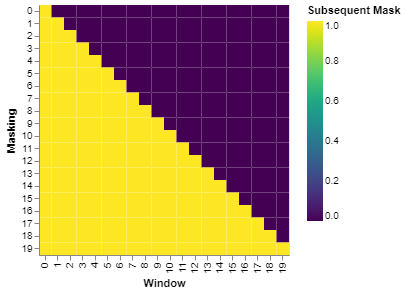

In [10]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

### Attention

An attention function can be described as mapping a query and a set
of key-value pairs to an output.  The output is computed as a weighted sum of
the values, where the weight assigned to each value is computed by a
compatibility function of the query with the corresponding key.

In practice, we compute the attention function on a set of queries
simultaneously, packed together into matrices $Q$, $K$ and $V$
$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$



In [11]:
def attention(query, key, value, mask=None, dropout=None):

    # ==================================== Complete the Code (Begin) ====================================
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))

    # Apply mask (if provided) 
    if mask is not None: 
        scores = scores.masked_fill(mask == 0, -1e9) 
    attention_weights = F.softmax(scores, dim=-1) 
    if dropout is not None: 
        attention_weights = dropout(attention_weights) 

    # Compute weighted sum of values 
    weighted_values = torch.matmul(attention_weights, value) 
    # ===================================== Complete the Code (End) =====================================

    return weighted_values, attention_weights



Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$
<br>
Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.
<br><br><br>

In this work we employ $h=8$ parallel attention layers, or
heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. 
Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    # ==================================== Complete the Code (Begin) ====================================
    
    def forward(self, query, key, value, mask=None): 

        n_batches = query.size(0)
        
        # Apply linear transformation to input queries, keys and value
        
        query = self.linears[0](query.to(self.linears[0].weight.dtype))
        key = self.linears[1](key.to(self.linears[0].weight.dtype))
        value = self.linears[2](value.to(self.linears[0].weight.dtype))
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # Concatenate and apply final linear transformation
        x = x.transpose(1, 2).contiguous().view(n_batches, -1, self.h * self.d_k)
        x = self.linears[-1](x)
        return x
    # ===================================== Complete the Code (End) =====================================

### Applications of Attention in our Model

In the Transformer architecture, attention is a fundamental component used in three different ways:

1.  **Encoder self-attention:** all keys, values, and queries are obtained from the output of the previous layer
2.  **Decoder self-attention (masked):**  Similarly, in Decoder self-attention, we use the output of the previous layer, but we need to prevent leftward information flow to preserve the auto-regressive property.
3.  **Decoder-encoder attention:** the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.  


This highlights the importance of attention in the Transformer architecture, and it is no surprise that the catchphrase for the Transformer is:
>  "Attention is all you need!"

## Position-wise Feed-Forward Networks

Position-wise Feed-Forward Networks are used in each layer of the encoder and decoder, which consist of two linear transformations with ReLU activation in between.

In [13]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    # ==================================== Complete the Code (Begin) ====================================
    def forward(self, x):
        x = self.w_1(x)
        x = self.w_2(self.dropout(F.relu(x)))
        return x
    
    # ===================================== Complete the Code (End) =====================================

## Embeddings and Softmax

The `Embeddings` class in our model learns embeddings to convert input and output tokens to vectors of dimension $d_{\text{model}}$. It applies a linear transformation and softmax function to generate predicted next-token probabilities. We share the same weight matrix between the embedding layers and the pre-softmax linear transformation, and multiply the weights in the embedding layers by $\sqrt{d_{\text{model}}}$.

In [14]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

The PositionalEncoding module is used in our model to provide information about the relative or absolute position of tokens in the input sequence. It is added to the input embeddings at the bottom of the encoder and decoder stacks.

The positional encodings have the same dimension as the embeddings and are implemented as sine and cosine functions of different frequencies. This is achieved using the following formulas:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$
$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position of the token and $i$ is the dimension index.



The following figure depicts a 128-dimensional positional encoding for a sentence with a maximum length of 50 tokens. Each row in the image represents the embedding vector for a specific token position in the sequence.
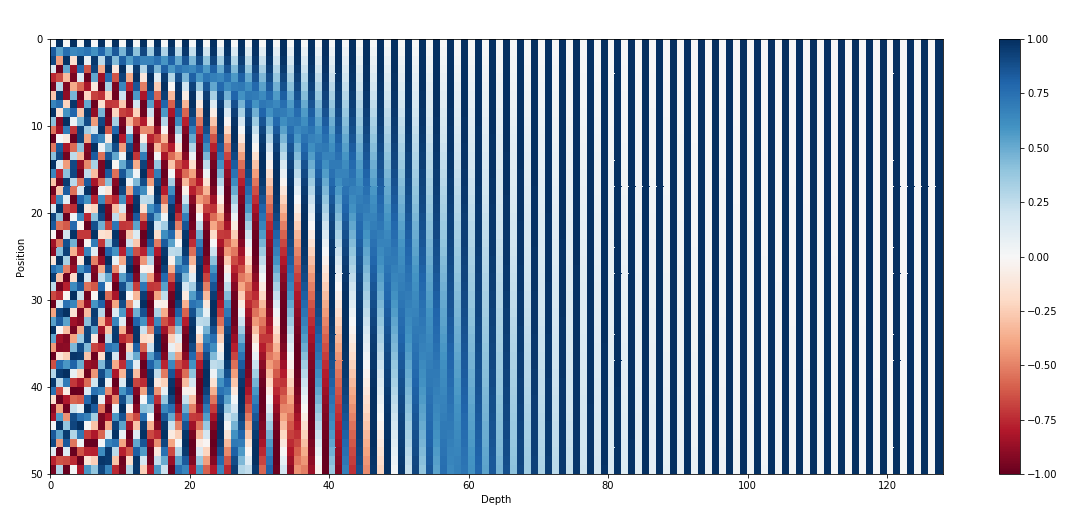

In [15]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## Full Model

Now that we have all the necessary components for our transformer model, we can put them together using the `make_model` function. This function takes in hyperparameters such as the source and target vocabulary sizes, the number of layers, and the dropout rate, and returns a fully constructed `EncoderDecoder` model.

Here are the definitions of each input:


*   `tgt_vocab`: The size of the target vocabulary.
*   `N`: The number of encoder and decoder layers.
*   `d_model`: The dimensionality of the model.
*   `d_ff`: The dimensionality of the feedforward layer.
*   `h`: The number of attention heads.
*   `dropout`: The dropout probability.

In [16]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Inference:

This cell is intended for testing purposes only. Please load this module to check for any potential bugs in your code and debug it in order to receive full mark.

In [17]:
def clones(layer,N):
    h = nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])
    return h
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print(f"Model Prediction: {ys}")


for _ in range(10):
    inference_test()


Model Prediction: tensor([[0, 9, 5, 8, 0, 9, 5, 8, 0, 9]])
Model Prediction: tensor([[0, 8, 9, 9, 9, 6, 6, 6, 6, 6]])
Model Prediction: tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Model Prediction: tensor([[ 0,  8, 10, 10, 10, 10, 10, 10, 10, 10]])
Model Prediction: tensor([[0, 1, 6, 9, 8, 7, 2, 4, 6, 9]])
Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Model Prediction: tensor([[0, 8, 2, 0, 8, 2, 6, 6, 6, 6]])
Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Model Prediction: tensor([[ 0,  1,  5,  8, 10,  9,  8, 10,  9,  4]])
Model Prediction: tensor([[0, 4, 9, 1, 9, 1, 9, 1, 9, 1]])
